#  **01: ETL - SENTIMENT 140**
### José Eduardo Viveros Escamilla | A01710605

Importacion de librerias necesarias 

In [66]:
import pandas as pd
import numpy as np
import re
import string
import emoji
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

stop_words = set(stopwords.words('english'))
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Carga y estructura del Dataset 
Leer correctamente el dataset Sentiment140, explorar su estructura básica y quedarnos solo con las columnas necesarias para el análisis de tendencias.

In [67]:
# Cargar el dataset
df = pd.read_csv(
    r'C:\Users\josed\Documents\IA\BENJI\data\raw_data\SENTIMENT_140.csv',
    encoding='latin-1',
    header=None
)
# Asignar nombres a las columnas (según estructura del Sentiment140)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Verificar estructura
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Eliminamos columnas inecesarias, nos quedamos con **target** que es el que nos indica basicamente el sentimiendo del tweet, la **fecha** con la que podria hacer el **analisis de tendencias** y el mismo **texto** del tweet

In [69]:
df = df[['target', 'date', 'text']]
df.head(5)

,target,date,text
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."


* En el contexto del data set solo tenemos dos variables que nos hablan acerca de como es percibido el tweet, al ser un un data set de Kaggle ya viene estandarizado para poder trabajar con el y con una feature muy especifica como lo puede ser esa



In [70]:
print("Valores únicos en 'target':", df['target'].unique())
print("Tamaño total del dataset:", len(df))
df['target'].value_counts()


Valores únicos en 'target': [0 4]
Tamaño total del dataset: 1600000


target
0    800000
4    800000
Name: count, dtype: int64

A si mismo normalizamos los datos a 0 y 1

In [71]:
df['target'] = df['target'].replace({4: 1})

### Analisis exploratorio de datos 

Solo graficamos la cantidad de tweets que tenemos que son 50/50 postivos y negativos

C:\Users\josed\AppData\Local\Temp\ipykernel_24000\436160857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette=['#FF6B6B', '#51CF66'])


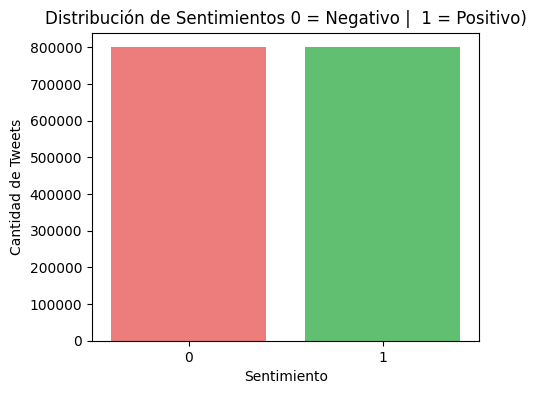

target
0    50.0
1    50.0
Name: proportion, dtype: float64


In [72]:
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df, palette=['#FF6B6B', '#51CF66'])
plt.title('Distribución de Sentimientos 0 = Negativo |  1 = Positivo)')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Tweets')
plt.show()

print(df['target'].value_counts(normalize=True)*100)

>Para ver como es que los tweets negavatvios y positivos se pueden ver imprimimos unos ejemplos randoms

In [73]:
print("Ejemplos de tweet NEGATIVOs :(\n", 
      "1", df[df['target']==0]['text'].iloc[34],
      "\n 2", df[df['target']==0]['text'].iloc[54],
      "\n 3", df[df['target']==0]['text'].iloc[67])

print("\nEjemplo de tweet POSITIVO :D\n", 
      "1",df[df['target']==1]['text'].iloc[78],
      "\n 2", df[df['target']==0]['text'].iloc[32],
      "\n 3", df[df['target']==0]['text'].iloc[88])

Ejemplos de tweet NEGATIVOs :(
 1 @HumpNinja I cry my asian eyes to sleep at night  
 2 I need a hug  
 3 Mo jobs, no money.  how in the hell is min wage here 4 f'n clams an hour?

Ejemplo de tweet POSITIVO :D
 1 had a good tech meeting at clubZone - dinner was sushi  
 2 thought sleeping in was an option tomorrow but realizing that it now is not. evaluations in the morning and work in the afternoon!  
 3 why is it always the fat ones?! 


Ahora nos pasamos a graficar el tamaño de los tweetes, esto atraves de nuestra feature **text** y ver como se comporta nuestar distribucion

Text(0.5, 1.0, 'Distribución de la longitud de los tweets por sentimiento')

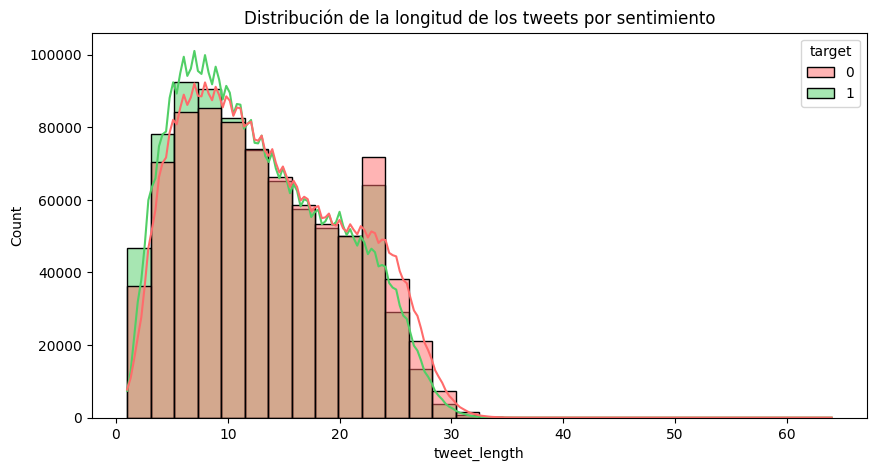

In [74]:
df['tweet_length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='tweet_length', hue='target', bins=30, kde=True, palette=['#FF6B6B', '#51CF66'])
plt.title('Distribución de la longitud de los tweets por sentimiento')

Viendo el resultado nos podemos dar cuenta que en si la mayoria delos tweets tiene en su mayoria entre 5 a 20 palabras, tanto negatviso como postivos, nos podemos dar cuenta en las lineas rojas y verdes qson muy similares pues la longitud de los tweets es muy similar 
* Esto significa que la longitud del tweet no predice el sentimiento de este

Con esto podemos visualizar las palabras mas utlizadas en ambos tipos de tweets, ya que ahi mismo es donde deberia que haber la doferencia entre los tweets si no es en la longitud deberia que ser en el contenido, asi que nos podemos dar una idea de esa forma

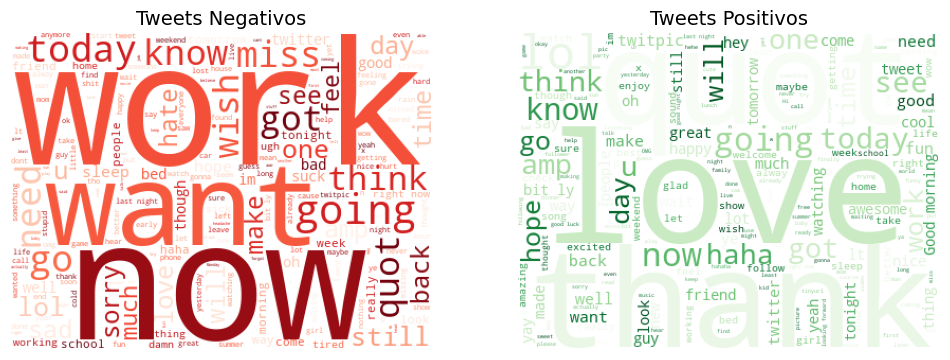

In [75]:
neg_text = " ".join(df[df['target']==0]['text'])
pos_text = " ".join(df[df['target']==1]['text'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=300, background_color='white', colormap='Reds').generate(neg_text))
plt.title('Tweets Negativos', fontsize=14)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=300, background_color='white', colormap='Greens').generate(pos_text))
plt.title('Tweets Positivos', fontsize=14)
plt.axis('off')

plt.show()


Las nubes muestran una clara distinción semántica entre los tweets positivos y negativos.
Los tweets negativos se asocian con temas de trabajo, cansancio o frustración, mientras que los positivos reflejan gratitud, alegría y relaciones personales. Esto nos confirma que el vocabulario del dataset tiene carga emocional significativa, y que nos puede ayudar a que nuestro modelo pueda reconocer emociones en palabras y esas emociones se pueden aplicar en muchos contextos lo cual es lo que necesaitmaos de este dataset.

* Conociendo mas que nada como los sentimientos se estan comportando con las palabras mas relevantes y ejemplos de los tweets, es buena idea poder ver como los sentimientos se van comportando conforme el tiempo (fecha) en el que se ralizaron los tweets.

C:\Users\josed\AppData\Local\Temp\ipykernel_24000\1580224698.py:1: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'])


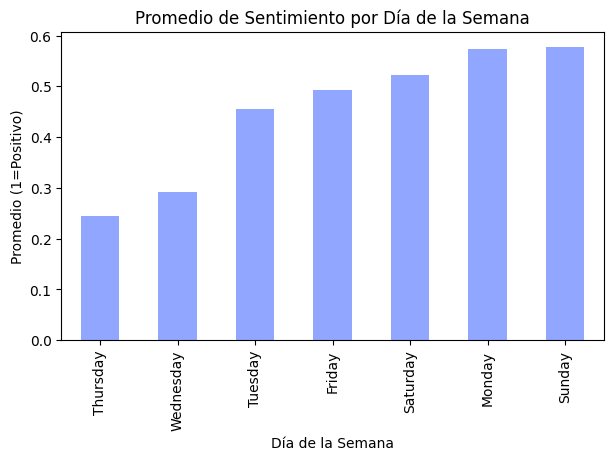

Periodo de fechas: 2009-04-06 22:19:45 → 2009-06-25 10:28:31


In [76]:
df['date'] = pd.to_datetime(df['date']) 
df['day_of_week'] = df['date'].dt.day_name()
sent_by_day = df.groupby('day_of_week')['target'].mean().sort_values()

plt.figure(figsize=(7,4))
sent_by_day.plot(kind='bar', color='#91A7FF')
plt.title('Promedio de Sentimiento por Día de la Semana')
plt.ylabel('Promedio (1=Positivo)')
plt.xlabel('Día de la Semana')
plt.show()

print(f"Periodo de fechas: {df['date'].min()} → {df['date'].max()}")
sent_by_day; # Agrega un punto y coma


Podemos ver la fecha solo contampla 3 meses del 2009, a pesar de que este dataset es algo viejo para poder predicir a nuevos tweets, es necesario para que el modelo pueda aprendar sentimientos, no tanto a identificar patrones en tweets que tengan que ver con una postura politica, esto solo nos ayudara a poder entender si el tweet es postivo o negativo.

### Limpieza y Procesamiento del Texto

In [77]:
def clean_text(text):
    # 1. A minúsculas
    text = text.lower()
    
    # 2. Quitar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Quitar menciones y hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # 4. Quitar números y puntuación
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 5. Quitar emojis
    text = emoji.replace_emoji(text, replace='')
    
    # 6. Quitar palabras vacías (stopwords)
    tokens = [word for word in text.split() if word not in stop_words]
    text = ' '.join(tokens)
    
    return text

df['clean_text'] = df['text'].astype(str).apply(clean_text)
df[['text', 'clean_text']].head(10)


,text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",thats bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see
5,@Kwesidei not the whole crew,whole crew
6,Need a hug,need hug
7,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time see yes rains bit bit lol im fin...
8,@Tatiana_K nope they didn't have it,nope didnt
9,@twittera que me muera ?,que muera


In [78]:
df.head()

,target,date,text,tweet_length,day_of_week,clean_text
0,0,2009-04-06 22:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",19,Monday,thats bummer shoulda got david carr third day
1,0,2009-04-06 22:19:49,is upset that he can't update his Facebook by ...,21,Monday,upset cant update facebook texting might cry r...
2,0,2009-04-06 22:19:53,@Kenichan I dived many times for the ball. Man...,18,Monday,dived many times ball managed save rest go bounds
3,0,2009-04-06 22:19:57,my whole body feels itchy and like its on fire,10,Monday,whole body feels itchy like fire
4,0,2009-04-06 22:19:57,"@nationwideclass no, it's not behaving at all....",21,Monday,behaving im mad cant see


Convertimos las palabras ya limpias en secuencias numericas para que el LSTM las pueda entender cuando le pasemos las features necesarias.

In [79]:

# Tamaño máximo del vocabulario (ajustable)
MAX_WORDS = 20000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# Guardar tokenizer para futuras etapas (v2 y v3)
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


In [80]:
X = np.array(padded_sequences)
y = df['target'].replace({4: 1}).values  # 0 = negativo, 1 = positivo

# Dividir en train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(1280000, 50) (160000, 50) (160000, 50)


Guardamos las secuencias listas para el modelo:

* X_train.npy - Tweets tokenizados (como secuencias numéricas)	
* X_val.npy - Tweets tokenizados para validación	
* X_test.npy - Tweets tokenizados para pruebas finales	
* y_train.npy, etc. - Etiquetas (0 = negativo, 1 = positivo)	
* tokenizer.pkl - Diccionario de palabras entrenado

In [81]:
os.makedirs('data/processed_data/v1_base', exist_ok=True)

# Guardar tokenizer
with open('data/processed_data/v1_base/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Guardar conjuntos procesados
np.save('data/processed_data/v1_base/X_train.npy', X_train)
np.save('data/processed_data/v1_base/X_val.npy', X_val)
np.save('data/processed_data/v1_base/X_test.npy', X_test)
np.save('data/processed_data/v1_base/y_train.npy', y_train)
np.save('data/processed_data/v1_base/y_val.npy', y_val)
np.save('data/processed_data/v1_base/y_test.npy', y_test)